In [1]:
import requests
import json
import os
import time
from ast import literal_eval

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt, timedelta

ModuleNotFoundError: No module named 'seaborn'

### Get Data

In [2]:
DS = '2022-08-01'

In [3]:
## https://www.blockchain.com/api/blockchain_api
url = 'https://blockchain.info'

def get_blocks(ds):
    ts = round((dt.strptime(ds,'%Y-%m-%d') + timedelta(days=1)).timestamp() * 1000)
    r = requests.get(f"{url}/blocks/{ts}?format=json")
    if r.status_code == 404:
        raise Exception("Request failed")
    return r.json()

def get_data_dir(ds):
    return os.path.join('btc_tx_data', DS.replace('-', '_'))

def get_fname(ds, n, batch=10):
    return os.path.join(get_data_dir(ds), f"tx_{n}_{n+batch-1}.json")

# retrieve bitcoin data for ds and save locally ('batch' blocks at a time)
def load_transactions(ds, batch=10):
    # save data locally
    data_dir = get_data_dir(ds)
    if not os.path.isdir(data_dir):
        os.mkdir(data_dir)
        
    # get block data (ensure always sorted by block index)
    blocks = sorted(get_blocks(DS), key= lambda d: d['block_index'])
    
    # load transaction data
    txs = []
    n = 1
    print(f'====== Getting transactions for {len(blocks)} blocks ======')
    while(n <= len(blocks)):  
        if (os.path.exists(get_fname(ds, n, batch))):
            print(f"{n+batch-1} blocks already loaded")  
            n+=batch
        else:
            h = blocks[n-1]['hash']
            r = requests.get(f"{url}/block/{h}?format=json") 

            if r.status_code == 404:
                raise Exception("Request failed")

            txs += r.json()['tx']

            if (n % batch == 0):
                # write to a file every 'batch' blocks
                with open(get_fname(ds, n-batch+1, batch), 'w') as f:
                    json.dump(tx, f)
                txs = []
                print(f"Completed {n} blocks")     
        
            n+=1

# get data from locally saved files on ds
def get_transactions(ds):
    data_dir = get_data_dir(ds)
    
    if not os.path.isdir(data_dir):
        raise Exception("Data not downloaded yet.")
    
    txs = []
    
    for fn in os.listdir(data_dir):
        if('.json' in fn):
            with open(os.path.join(data_dir, fn), 'r') as f:
                txs += json.load(f)
    return txs

In [4]:
load_transactions(DS)
txs = get_transactions(DS)

====== Getting transactions for 149 blocks ======
10 blocks already loaded
20 blocks already loaded
30 blocks already loaded
40 blocks already loaded
50 blocks already loaded
60 blocks already loaded
70 blocks already loaded
80 blocks already loaded
90 blocks already loaded
100 blocks already loaded
110 blocks already loaded
120 blocks already loaded
130 blocks already loaded
140 blocks already loaded


In [5]:
len(txs)

256287

## Clean Data

In [6]:
def extract_data(tx):
    return {'hash': tx['hash'],
            'time': tx['time'], 
            'input_addr': sorted(list(filter(None, [i['prev_out'].get('addr') for i in tx['inputs']]))),
            'output_addr': sorted(list(filter(None, [o.get('addr') for o in tx['out']]))), 
            'input_value_tot': sum([int(i['prev_out'].get('value')) for i in tx['inputs']]),
            'output_value_tot': sum([int(o.get('value')) for o in tx['out']]),
            'fee': tx['fee']}

# NOTE: value is in 10e-8 BTC

In [7]:
df = pd.DataFrame([extract_data(tx) for tx in txs])

In [8]:
df['dt_time'] = [dt.fromtimestamp(t) for t in df['time']]
df['n_outputs'] = [len(o) for o in df['output_addr']]
df['n_inputs'] = [len(i) for i in df['input_addr']]
df['output_addr_str'] = [','.join(addr) for addr in df['output_addr']]
df['input_addr_str'] = [','.join(addr) for addr in df['input_addr']]

# rough btc to usd conversion
cvr = 1e-8 * 22000
df['input_value_tot_usd'] = round(df['input_value_tot'] * cvr, 2)
df['output_vaue_tot_usd'] = round(df['output_value_tot'] * cvr, 2)


# get start time, assuming that start at a whole hour
start_dt = df.dt_time.min().replace(second = 0, minute = 0)

# discrete time unit in minutes (use 1 minute)
D = 1

# assign create times to discrete epochs
def get_epoch(ts, start, D):
    return int(np.floor((ts - start).total_seconds() / (60. * D)))

df['epoch'] = [get_epoch(ts, start_dt, D) for ts in df['dt_time']]

df =  df[(df.input_value_tot > 0) 
             & (df.output_value_tot > 0)
             & (df.output_addr_str != '')
             & (df.input_addr_str != '')]

In [9]:
# get (output addr) x (epoch) where multiple input addr sent to the same output 
multiple = df.groupby(['output_addr_str', 'epoch'])['input_addr_str'].nunique()
m = multiple[multiple > 1].index

In [10]:
df_multi = df.set_index(['output_addr_str', 'epoch']).loc[m].reset_index()

In [11]:
df_multi.head(10)

,output_addr_str,epoch,hash,time,input_addr,output_addr,input_value_tot,output_value_tot,fee,dt_time,n_outputs,n_inputs,input_addr_str,input_value_tot_usd,output_vaue_tot_usd
0,1215bzNH2G2jVcgToAaxtaC3My6BamqvVc,1015,16b7785b3baf60e62f73851774f5a67e2b558e7a8c90ea...,1659376517,[bc1qptal06y9hedtc3t7a2468dnjle4kl2kgp36nfa],[1215bzNH2G2jVcgToAaxtaC3My6BamqvVc],10000000,9996820,3180,2022-08-01 13:55:17,1,1,bc1qptal06y9hedtc3t7a2468dnjle4kl2kgp36nfa,2200.00,2199.30
1,1215bzNH2G2jVcgToAaxtaC3My6BamqvVc,1015,f25b64579f6838e491199129307ebfa1f4634b47760a51...,1659376541,[1JKtgVyaVEVxZ4tnts7oywaQRhnHsXSKji],[1215bzNH2G2jVcgToAaxtaC3My6BamqvVc],15000000,14996820,3180,2022-08-01 13:55:41,1,1,1JKtgVyaVEVxZ4tnts7oywaQRhnHsXSKji,3300.00,3299.30
2,124yvJcUW5da2cgctQucenm2LBMKDKExWc,1316,b3bfe911c20f8457942c2a5f20877b26e548e6b39bd03d...,1659394560,[1GmXnNKPMg4SBAj9oD3eFa72fRyQJh1fvU],[124yvJcUW5da2cgctQucenm2LBMKDKExWc],450992,449792,1200,2022-08-01 18:56:00,1,1,1GmXnNKPMg4SBAj9oD3eFa72fRyQJh1fvU,99.22,98.95
3,124yvJcUW5da2cgctQucenm2LBMKDKExWc,1316,8b2acc1e783ff28de3d448c82c0b57030cdd5ccb61b1a0...,1659394560,[1E1PQ7jrKBMtghxXyDjLJJFap2H7kNNJM3],[124yvJcUW5da2cgctQucenm2LBMKDKExWc],640200,639000,1200,2022-08-01 18:56:00,1,1,1E1PQ7jrKBMtghxXyDjLJJFap2H7kNNJM3,140.84,140.58
4,12LmCGL92PbNJ8t6nyRUkB98D9UFe8myjt,390,6b41ee21ec8af255f94f201d9b60a52ff8bb3227888de5...,1659339027,"[bc1q2q87vdv4kmaz50g7n9qxqsrrm5p32s5nfdrnrw, b...",[12LmCGL92PbNJ8t6nyRUkB98D9UFe8myjt],73239784,73232996,6788,2022-08-01 03:30:27,1,5,"bc1q2q87vdv4kmaz50g7n9qxqsrrm5p32s5nfdrnrw,bc1...",16112.75,16111.26
5,12LmCGL92PbNJ8t6nyRUkB98D9UFe8myjt,390,cf8903ba9dcdbf84a2c326d87c1239c85f74c75480af3e...,1659339025,"[bc1q0u5w2ks73dknk7uru3hyvav2rn2l4aqdx3u04p, b...",[12LmCGL92PbNJ8t6nyRUkB98D9UFe8myjt],306561685,306555140,6545,2022-08-01 03:30:25,1,9,"bc1q0u5w2ks73dknk7uru3hyvav2rn2l4aqdx3u04p,bc1...",67443.57,67442.13
6,"12LmCGL92PbNJ8t6nyRUkB98D9UFe8myjt,bc1qvzmym6q...",334,1693ec6cd0309ad3d2106cd9c5f981187f490d9b26f9eb...,1659335647,[bc1qv3xqm2tqunqeyr6nnll8sv0ch3kwu7prlw4yvf],"[12LmCGL92PbNJ8t6nyRUkB98D9UFe8myjt, bc1qvzmym...",11471945,11471609,336,2022-08-01 02:34:07,2,1,bc1qv3xqm2tqunqeyr6nnll8sv0ch3kwu7prlw4yvf,2523.83,2523.75
7,"12LmCGL92PbNJ8t6nyRUkB98D9UFe8myjt,bc1qvzmym6q...",334,f5aea768ef3596471a4a0643d37084b0f931480de5e222...,1659335660,[bc1qvzmym6qqppw79gy9932cz9suun7c65vxy5dh58],"[12LmCGL92PbNJ8t6nyRUkB98D9UFe8myjt, bc1qvzmym...",10591757,10591421,336,2022-08-01 02:34:20,2,1,bc1qvzmym6qqppw79gy9932cz9suun7c65vxy5dh58,2330.19,2330.11
8,"12LmCGL92PbNJ8t6nyRUkB98D9UFe8myjt,bc1qvzmym6q...",334,a05fd1aaac7f071d73acba866771f955e4a09f14980a6c...,1659335689,[bc1q7qkrwsfhd2gf0h2htt44qfgwc4kng9wfwfkdup],"[12LmCGL92PbNJ8t6nyRUkB98D9UFe8myjt, bc1qvzmym...",10184202,10183866,336,2022-08-01 02:34:49,2,1,bc1q7qkrwsfhd2gf0h2htt44qfgwc4kng9wfwfkdup,2240.52,2240.45
9,12gVsQE3uEJJTKcisK71875FUe4jXVc6mj,310,3a03ab374785f004adf96519d6d682004abce9aadc2e0e...,1659334231,[18F8kWf1FQzoSaUeXzuUMtsaDSuDYj7PkJ],[12gVsQE3uEJJTKcisK71875FUe4jXVc6mj],947483,940623,6860,2022-08-01 02:10:31,1,1,18F8kWf1FQzoSaUeXzuUMtsaDSuDYj7PkJ,208.45,206.94


In [12]:
df.shape

(256116, 15)

In [13]:
df_multi.shape

(3834, 15)

In [14]:
df_multi.output_vaue_tot_usd.sum()

1423601305.8400002

In [16]:
df.groupby('epoch').count().hash

epoch
56        1
57        3
58        4
59        2
60        6
       ... 
1558    121
1559    113
1560    158
1561    132
1562     11
Name: hash, Length: 1506, dtype: int64

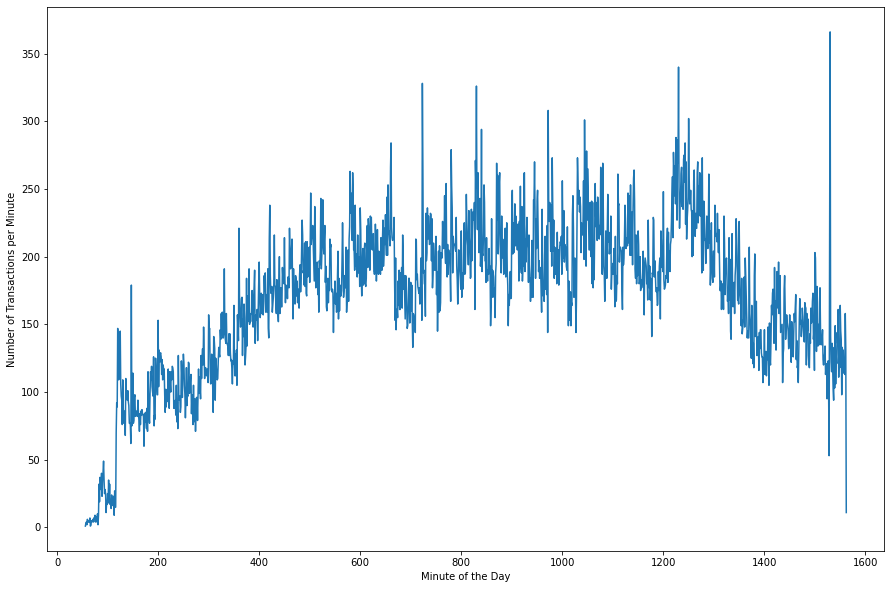

In [30]:
fig, ax = plt.subplots(figsize=(15,10))

plt.plot(df.groupby('epoch').count().hash)
plt.xlabel('Minute of the Day')
plt.ylabel('Number of Transactions per Minute')

plt.show()

### Get Additional Account Data

In [39]:
## https://blockchair.com/api/docs#link_M2
url2 = 'https://api.blockchair.com/bitcoin/dashboards'

def get_addr_data(a):
    r = requests.get(f"{url2}/address/{a}/?transaction_details=true&limit=100")
    
    if r.status_code == 429:
        raise Exception("Hit rate limit.")
    
    if r.status_code != 200:
        return None
    
    d = r.json()['data'][a]
        
    # get transaction receivd by the address
    times = [tx['time'] for tx in d['transactions'] if tx['balance_change'] > 0]
    
    return {'addr': a,
            'first_seen_receiving': d['address']['first_seen_receiving'],
            'total_received': d['address']['received'],
            'total_received_usd': d['address']['received_usd'],
            'lifetime_tx_count': d['address']['transaction_count'],
            'incoming_tx_times': times}

def load_all_addr_data(addrs, ds=DS, batch=25):
    def get_addr_file(data_dir, n, batch):
        return os.path.join(data_dir, f'addr{int(np.floor(n/batch))}.csv')
    
    data_dir = os.path.join(get_data_dir(ds), 'addr')
    if not os.path.isdir(data_dir):
        os.mkdir(data_dir)
    
    n = 0
    n_err = 0
    addr_data = []
    
    print(f'===== Fetching data for {len(addrs)} addresses =====')
    while n < len(addrs):
        if os.path.exists(get_addr_file(data_dir, n, batch)):
            print(f"{n+batch} addresses already loaded")  
            n+=batch
            
        else:
            data = get_addr_data(addrs[n])
            time.sleep(5) # delay 5 seconds to prevent rate limit (> 30 a minute)
            
            if data == None:
                n_err += 1
            else:
                addr_data += [data]
                
            if (n+1) % batch == 0:
                if 100 * n_err / batch >= 5:
                    print(f'Too many errors, failed on {n+1} addresses')
                else:
                    # save data frame to file
                    pd.DataFrame(addr_data).to_csv(get_addr_file(data_dir, n-1, batch))
                    print(f'Completed {n+1} addresses')
                n_err = 0
                addr_data = []
            n += 1
            
    print(f'Completed {n+1} addresses') 

# get data from locally saved files on ds
def get_addresses(ds=DS):
    
    def parse_time_list(s):
        l = literal_eval(s)
        return sorted([dt.strptime(t, '%Y-%m-%d %H:%M:%S') for t in l])
    
    data_dir = os.path.join(get_data_dir(ds), 'addr')
    
    if not os.path.isdir(data_dir):
        raise Exception("Data not downloaded yet.")
    
    addrs = []
    
    for fn in os.listdir(data_dir):
        if('.csv' in fn):
            with open(os.path.join(data_dir, fn), 'r') as f:
                d = pd.read_csv(f, index_col = 0)
                d.incoming_tx_times = d.incoming_tx_times.apply(parse_time_list)
                addrs += [d]
                
    return pd.concat(addrs).reset_index(drop=True)

In [40]:
df_multi_addr = df_multi[df_multi.n_outputs == 1]
addrs = df_multi_addr['output_addr_str'].unique()

load_all_addr_data(addrs)

===== Fetching data for 344 addresses =====
25 addresses already loaded
50 addresses already loaded
75 addresses already loaded
100 addresses already loaded
125 addresses already loaded
150 addresses already loaded
175 addresses already loaded
200 addresses already loaded
225 addresses already loaded
250 addresses already loaded
275 addresses already loaded
300 addresses already loaded
325 addresses already loaded
Completed 345 addresses


In [41]:
df_addr_data = get_addresses()

In [42]:
df1 = df_multi_addr.set_index('output_addr_str')
df2 = df_addr_data.set_index('addr'),
df_all = df1.join(df2, how='inner').reset_index().rename(columns={'index': 'addr'})

In [43]:
df_all.head()

,addr,epoch,hash,time,input_addr,output_addr,input_value_tot,output_value_tot,fee,dt_time,n_outputs,n_inputs,input_addr_str,input_value_tot_usd,output_vaue_tot_usd,first_seen_receiving,total_received,total_received_usd,lifetime_tx_count,incoming_tx_times
0,1215bzNH2G2jVcgToAaxtaC3My6BamqvVc,1015,16b7785b3baf60e62f73851774f5a67e2b558e7a8c90ea...,1659376517,[bc1qptal06y9hedtc3t7a2468dnjle4kl2kgp36nfa],[1215bzNH2G2jVcgToAaxtaC3My6BamqvVc],10000000,9996820,3180,2022-08-01 13:55:17,1,1,bc1qptal06y9hedtc3t7a2468dnjle4kl2kgp36nfa,2200.00,2199.30,2017-03-28 04:19:11,88342311,1.215859e+04,23,"[2017-03-28 04:19:11, 2017-03-28 04:19:11, 201..."
1,1215bzNH2G2jVcgToAaxtaC3My6BamqvVc,1015,f25b64579f6838e491199129307ebfa1f4634b47760a51...,1659376541,[1JKtgVyaVEVxZ4tnts7oywaQRhnHsXSKji],[1215bzNH2G2jVcgToAaxtaC3My6BamqvVc],15000000,14996820,3180,2022-08-01 13:55:41,1,1,1JKtgVyaVEVxZ4tnts7oywaQRhnHsXSKji,3300.00,3299.30,2017-03-28 04:19:11,88342311,1.215859e+04,23,"[2017-03-28 04:19:11, 2017-03-28 04:19:11, 201..."
2,124yvJcUW5da2cgctQucenm2LBMKDKExWc,1316,b3bfe911c20f8457942c2a5f20877b26e548e6b39bd03d...,1659394560,[1GmXnNKPMg4SBAj9oD3eFa72fRyQJh1fvU],[124yvJcUW5da2cgctQucenm2LBMKDKExWc],450992,449792,1200,2022-08-01 18:56:00,1,1,1GmXnNKPMg4SBAj9oD3eFa72fRyQJh1fvU,99.22,98.95,2021-12-03 11:23:28,7616518084,2.948682e+06,1797,"[2022-07-25 14:33:53, 2022-07-25 19:13:09, 202..."
3,124yvJcUW5da2cgctQucenm2LBMKDKExWc,1316,8b2acc1e783ff28de3d448c82c0b57030cdd5ccb61b1a0...,1659394560,[1E1PQ7jrKBMtghxXyDjLJJFap2H7kNNJM3],[124yvJcUW5da2cgctQucenm2LBMKDKExWc],640200,639000,1200,2022-08-01 18:56:00,1,1,1E1PQ7jrKBMtghxXyDjLJJFap2H7kNNJM3,140.84,140.58,2021-12-03 11:23:28,7616518084,2.948682e+06,1797,"[2022-07-25 14:33:53, 2022-07-25 19:13:09, 202..."
4,12LmCGL92PbNJ8t6nyRUkB98D9UFe8myjt,390,6b41ee21ec8af255f94f201d9b60a52ff8bb3227888de5...,1659339027,"[bc1q2q87vdv4kmaz50g7n9qxqsrrm5p32s5nfdrnrw, b...",[12LmCGL92PbNJ8t6nyRUkB98D9UFe8myjt],73239784,73232996,6788,2022-08-01 03:30:27,1,5,"bc1q2q87vdv4kmaz50g7n9qxqsrrm5p32s5nfdrnrw,bc1...",16112.75,16111.26,2021-05-24 13:52:58,97946083072,2.227452e+07,1384,"[2022-08-02 09:20:36, 2022-08-02 13:06:29, 202..."


In [47]:
df.shape

(256116, 15)

In [44]:
df_all.shape

(3048, 20)

In [51]:
np.sum(df_all.output_vaue_tot_usd)

1339010912.73

In [45]:
batch_sizes = df_all.groupby(['epoch', 'addr'])['time'].count()
batch_sizes[batch_sizes == 2].count()

# total # of instances of batching
len(batch_sizes)

887

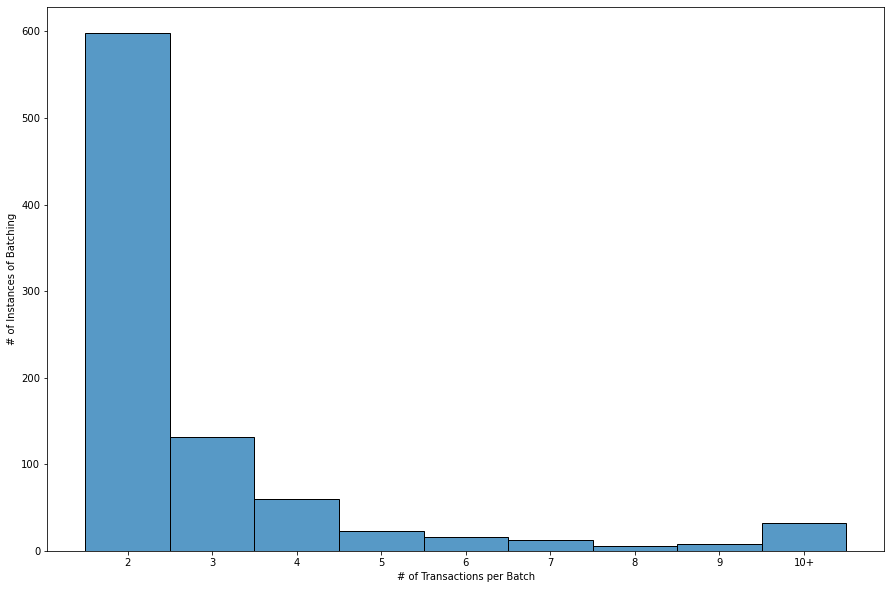

In [46]:
fig, axes = plt.subplots(figsize=(15,10))

cat = [min(b, 10) for b in batch_sizes]
sns.histplot(cat, bins = np.arange(2,12))

plt.xticks(np.arange(2,11)+0.5, labels=[str(n) for n in np.arange(2,10)] + ['10+'])

plt.ylabel('# of Instances of Batching')
plt.xlabel('# of Transactions per Batch')
plt.show()

In [54]:
def get_interarrival_time_dist(times, p=75):
    diffs = np.diff(times)
    zeros = sum(diffs == timedelta(0))
    if zeros == len(diffs):
        return np.inf
    else:
        return np.percentile(diffs[diffs != timedelta(0)], p)

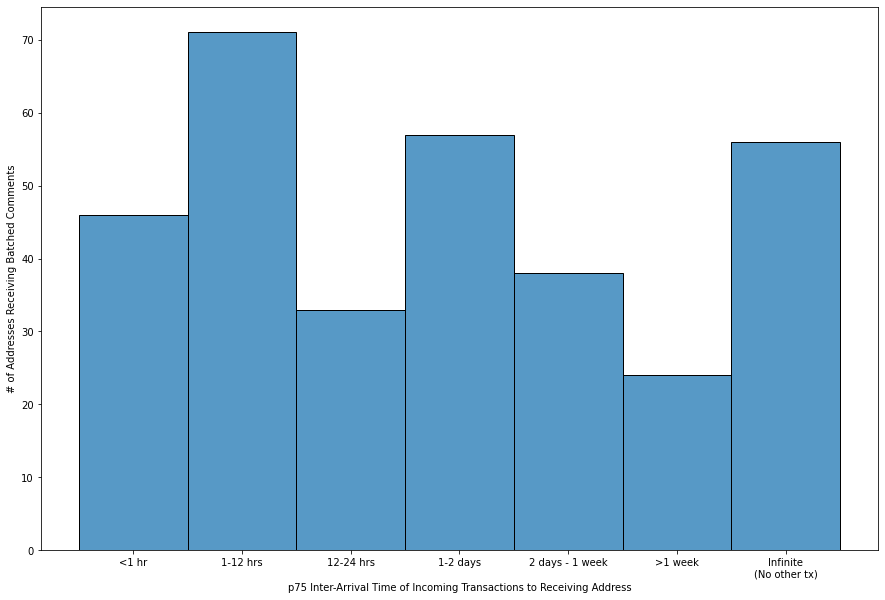

In [55]:
df_all['gap_time'] = df_all.incoming_tx_times.apply(get_interarrival_time_dist)
gap_times = df_all.groupby(['addr'])['gap_time'].max()

fig, axes = plt.subplots(figsize=(15,10))

def bucket_time(t):
    if t == np.inf:
        return 6
    if t <= timedelta(minutes = 60):
        return 0
    if t <= timedelta(minutes = 60*12):
        return 1
    if t <= timedelta(minutes = 60*24):
        return 2
    if t <= timedelta(minutes = 60*48):
        return 3
    if t <= timedelta(minutes = 60 * 24 * 7):
        return 4
    return 5

sns.histplot(gap_times.apply(bucket_time), bins = np.arange(0,8))

plt.xticks(np.arange(0,7)+0.5, labels=['<1 hr', '1-12 hrs', '12-24 hrs', '1-2 days', '2 days - 1 week', 
                                      '>1 week', 'Infinite\n(No other tx)'])

plt.ylabel('# of Addresses Receiving Batched Comments')
plt.xlabel('p75 Inter-Arrival Time of Incoming Transactions to Receiving Address')
plt.show()

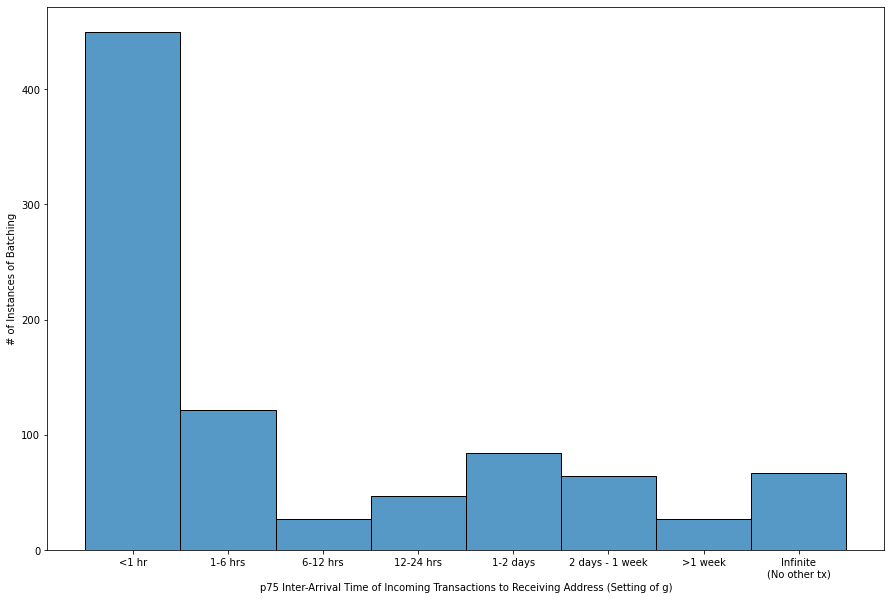

In [103]:
gap_times = df_all.groupby(['addr', 'epoch'])['gap_time'].max()

fig, axes = plt.subplots(figsize=(15,10))

def bucket_time(t):
    if t == np.inf:
        return 7
    if t <= timedelta(minutes = 60):
        return 0
    if t <= timedelta(minutes = 60*6):
        return 1
    if t <= timedelta(minutes = 60*12):
        return 2
    if t <= timedelta(minutes = 60*24):
        return 3
    if t <= timedelta(minutes = 60*48):
        return 4
    if t <= timedelta(minutes = 60 * 24 * 7):
        return 5
    return 6

sns.histplot(gap_times.apply(bucket_time), bins = np.arange(0,9))

plt.xticks(np.arange(0,8)+0.5, labels=['<1 hr', '1-6 hrs', '6-12 hrs', '12-24 hrs', '1-2 days', '2 days - 1 week', 
                                      '>1 week', 'Infinite\n(No other tx)'])

plt.ylabel('# of Instances of Batching')
plt.xlabel('p75 Inter-Arrival Time of Incoming Transactions to Receiving Address (Setting of g)')
plt.show()

In [80]:
gap_times = df_all.groupby(['addr', 'epoch'])['gap_time'].max()

In [89]:
df_all.dt_time

0      2022-08-01 13:55:17
1      2022-08-01 13:55:41
2      2022-08-01 18:56:00
3      2022-08-01 18:56:00
4      2022-08-01 03:30:27
               ...        
3043   2022-08-01 10:50:43
3044   2022-08-01 10:50:43
3045   2022-08-01 10:50:43
3046   2022-08-01 13:12:27
3047   2022-08-01 13:12:10
Name: dt_time, Length: 3048, dtype: datetime64[ns]

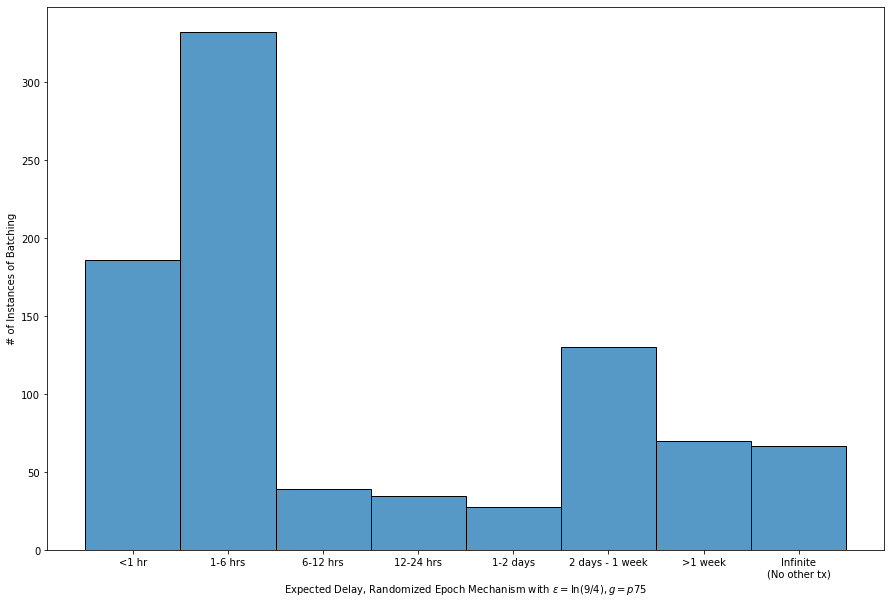

In [102]:
gap_times = 2.5 * df_all.groupby(['addr', 'epoch'])['gap_time'].max()

fig, axes = plt.subplots(figsize=(15,10))

def bucket_time(t):
    if t == np.inf:
        return 7
    if t <= timedelta(minutes = 60):
        return 0
    if t <= timedelta(minutes = 60*6):
        return 1
    if t <= timedelta(minutes = 60*12):
        return 2
    if t <= timedelta(minutes = 60*24):
        return 3
    if t <= timedelta(minutes = 60*48):
        return 4
    if t <= timedelta(minutes = 60 * 24 * 7):
        return 5
    return 6

sns.histplot(gap_times.apply(bucket_time), bins = np.arange(0,9))

plt.xticks(np.arange(0,8)+0.5, labels=['<1 hr', '1-6 hrs', '6-12 hrs', '12-24 hrs', '1-2 days', '2 days - 1 week', 
                                      '>1 week', 'Infinite\n(No other tx)'])

plt.ylabel('# of Instances of Batching')
plt.xlabel(r'Expected Delay, Randomized Epoch Mechanism with $\epsilon = \ln(9/4), g=p75$')
plt.show()

In [ ]:
K = 2


In [67]:
df_times_per_addr = df.groupby('output_addr_str').time.apply(list)

In [79]:
two_trans = [np.abs(dt.fromtimestamp(t[0]) - dt.fromtimestamp(t[1])) 
                 for t in df_times_per_addr if len(t) == 2]
str(np.percentile(two_trans, 75))

'7:07:35.500000'

### Aside: Fee Rate per Size of Transaction

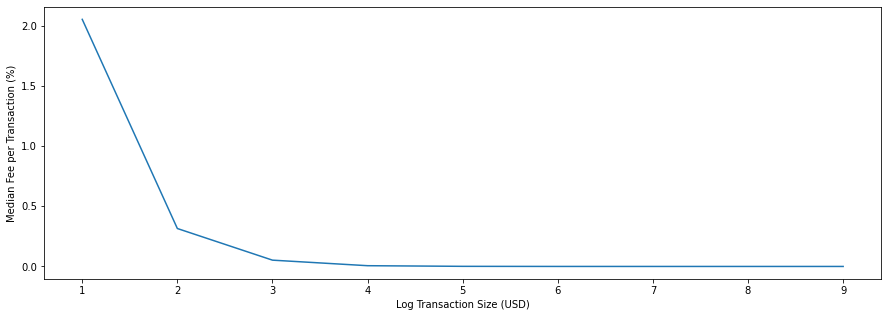

In [131]:
fig,axis = plt.subplots(figsize=(15,5))

df_fee= pd.DataFrame({'log_value': round(np.log10(df.input_value_tot_usd)), 
                      'fee_pct': 100. * df.fee / df.input_value_tot})

plt.plot(df_fee[df_fee.log_value > 0].groupby('log_value').fee_pct.median())
plt.xticks(sorted(df_fee[df_fee.log_value > 0].log_value.unique()))
plt.ylabel("Median Fee per Transaction (%)")
plt.xlabel("Log Transaction Size (USD)")
plt.show()